### Imports

In [2]:
import pandas as pd 
import os
%matplotlib inline
   
from utils import *
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from tensorflow.keras.models import Model

2022-04-19 11:39:02.535450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 11:39:02.535470: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Loading Images

In [3]:
image_dir="/home/pedrod33/Desktop/MRSI/ano1s2/AA/Brain_Tumor_Detection/archive/brain_tumor_dataset/"

### Making directory for augmented images

**A directory is formed using os.makedirs() function for augmented images(yes/ no). Note- custom directory is obtained in outputs folder.**

In [4]:

#os.makedirs('../output/kaggle/working/augmented-images')
#os.makedirs('../output/kaggle/working/augmented-images/yes')
#os.makedirs('../output/kaggle/working/augmented-images/no')

## Augmentation of images 
**About the data:
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous andno contains 98 Brain MRI Images that are non-tumorous.**

In [5]:
augmented_data_path ='../output/kaggle/working/augmented-images/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

## Preprocessing the data

In order to crop the specific part of the image containing tumour,cropping technique via OpenCv is used, the details can be found here.[How to find extreme points in OpenCv?](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

## After applying the cropping function

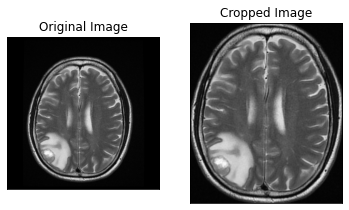

In [6]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [7]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (164, 164)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 164, 164, 3)
y shape is: (2065, 1)


## Visualization of data

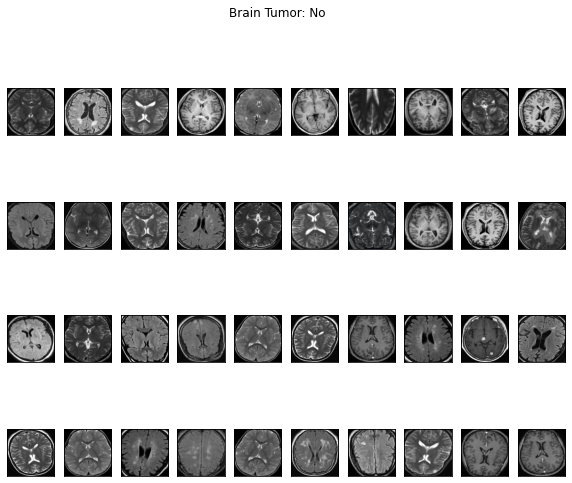

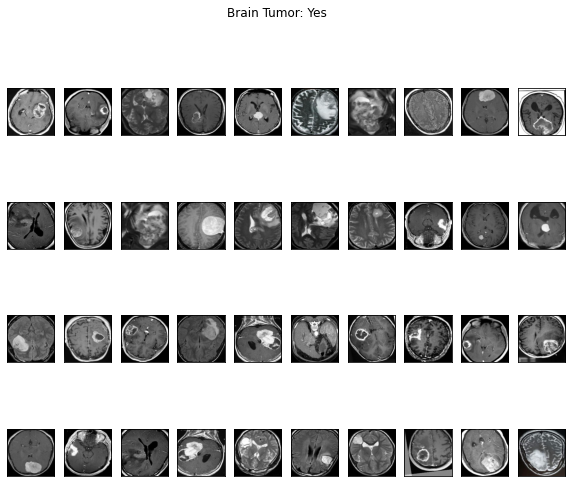

In [8]:
plot_sample_images(X, y)

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1445
number of validation examples = 310
number of test examples = 310


In [ ]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [11]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 164, 164, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 168, 168, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 162, 162, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 162, 162, 32)      128       
                                                                 
 activation (Activation)     (None, 162, 162, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                           

2022-04-19 11:40:43.033590: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-19 11:40:43.033620: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pedrod33): /proc/driver/nvidia/version does not exist
2022-04-19 11:40:43.034527: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

2022-04-19 11:40:43.290675: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 466376640 exceeds 10% of free system memory.


Epoch 1/22
46/46 [==============================] - 41s 888ms/step - loss: 0.7285 - accuracy: 0.6464 - val_loss: 0.6442 - val_accuracy: 0.7194
Epoch 2/22
46/46 [==============================] - 39s 860ms/step - loss: 0.4750 - accuracy: 0.7799 - val_loss: 0.6029 - val_accuracy: 0.8419
Epoch 3/22
46/46 [==============================] - 41s 903ms/step - loss: 0.4178 - accuracy: 0.8256 - val_loss: 0.5783 - val_accuracy: 0.7581
Epoch 4/22
46/46 [==============================] - 40s 870ms/step - loss: 0.3918 - accuracy: 0.8388 - val_loss: 0.5293 - val_accuracy: 0.8355
Epoch 5/22
46/46 [==============================] - 40s 871ms/step - loss: 0.3948 - accuracy: 0.8235 - val_loss: 0.5520 - val_accuracy: 0.7129
Epoch 6/22
46/46 [==============================] - 40s 870ms/step - loss: 0.3549 - accuracy: 0.8540 - val_loss: 0.4327 - val_accuracy: 0.8290
Epoch 7/22
46/46 [==============================] - 41s 891ms/step - loss: 0.3113 - accuracy: 0.8713 - val_loss: 0.5121 - val_accuracy: 0.7065

In [13]:
history = model.history.history

### Plotting of aaccuracy

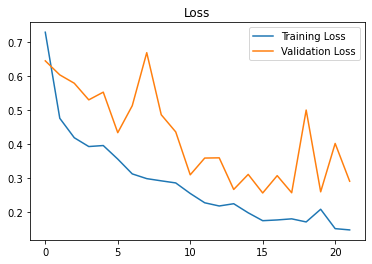

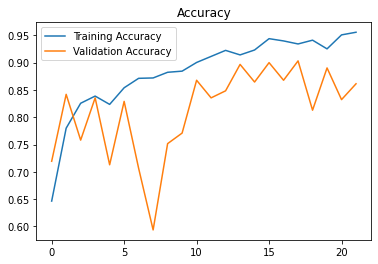

In [14]:
plot_metrics(history)